<h1 style="text-align: center">Analysis of collected Data</h1>

1. [Introduction](#introduction) <br>
2. [Project preparation](#project_preparation) <br>
    2.1 [Imports](#imports) <br>
    2.2 [Setup](#setup) <br>
    2.3 [Load data](#loaddata)
3. [Analysis / Visialization](#analysis) <br>
    3.1 [Basic information](#basic) <br>
    3.2 [Weekly data](#weeklydata) <br>
    3.3 [Let's do some linear regression](#lr) <br>
    3.4 [Are there any correlations?](#corr) <br>
    3.5 [Time for Tensorflow!](#tf) <br>
    &emsp;&emsp;


# 1. Introduction <a name="introduction"></a>

This notebook is designed to examine the data collected by pepper using various tools and techniques to uncover anomalies within the data, as well as to improve the overall quality of pepper by addressing weaknesses and refocusing on the data.



There are several tables in our mysql database ( database name: pepperbackend )        

- pepper_conversation_table       
<table>
    <th>
        <td>data_id</td>
        <td>identifier</td>
        <td>data</td>
        <td>ts</td>
    </th>
    <tr>
        <td>1</td>
        <td>1</td>
        <td>cd305834cd3f47be9c2e654e1b3c5dad</td>
        <td>"{"attributes": {"hair": "white", "eyes": "green", "body": "normal"}}"</td>
        <td>2022-01-11 13:34:50</td>
    </tr>
</table>


- pepper_did_not_understand_table 

<table>
    <th>
        <td>data_id</td>
        <td>identifier</td>
        <td>phrase</td>
        <td>ts</td>
    </th>
    <tr>
        <td>1</td>
        <td>1</td>
        <td>7ce287b890cd497c9c2ae05c1dd2ae20</td>
        <td>wieho</td>
        <td>2022-01-11 13:34:50</td>
    </tr>
</table>

- pepper_emotion_table     
<table>
    <th>
        <td>data_id</td>
        <td>identifier</td>
        <td>distance</td>
        <td>age</td>
        <td>gender</td>
        <td>basic_emotion</td>
        <td>pleasure_state</td>
        <td>excitement_state</td>
        <td>smile_state</td>
        <td>dialog_time</td>
        <td>ts</td>
    </th>
    <tr>
        <td>1</td>
        <td>1</td>
        <td>cd305834cd3f47be9c2e654e1b3c5dad</td>
        <td>1.7878</td>
        <td>43</td>
        <td>male</td>
        <td>good</td>
        <td>perfect</td>
        <td>excited</td>
        <td>True</td>
        <td>3.04</td>
        <td>2022-01-11 13:34:50</td>
    </tr>
</table>       

- pepper_use_case_table     

<table>
    <th>
        <td>data_id</td>
        <td>identifier</td>
        <td>use_case</td>
        <td>ts</td>
    </th>
    <tr>
        <td>1</td>
        <td>1</td>
        <td>7ce287b890cd497c9c2ae05c1dd2ae20</td>
        <td>SmallTalk</td>
        <td>2022-01-11 13:34:50</td>
    </tr>
</table>               

____

To be able to access the data of the tables, a class named "Client" was created, with which you can easily read and write data from the database.

To prevent the database from being edited externally or sensitive data from being read, the endpoint is restricted, which is why the following command, for example, is not possible:

```python
client.sql_query("select * from users")
Exception: 401-Invalid SQL command!
```
____
# 2. Project preparation <a name="project_preparation"></a>

Before the actual visualization and analysis of the data, various packages have to be imported and settings have to be made.

## 2.1 Imports <a name="imports"></a>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import dotenv_values

from sklearn.linear_model import LinearRegression
import tensorflow as tf

from Client import Client

In [2]:
%matplotlib inline
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = [10, 6]
plt.style.use("fivethirtyeight")

_red, _orange, _gray, _green, _blue = "#fc4f30", "#e5ae38", "#8b8b8b", "#6d904f", "#30a2da"
_weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

____
## 2.2 Setup <a name="setup"></a>

In [3]:
config = dotenv_values(".env") 
API_KEY = config["API_KEY"]
MAX_ROWS = 500

In [4]:
client = Client(API_KEY, sandbox=False) # create client to connect with web-app 

{'message': 'Connected!'}


____
## 2.3 Load Data <a name="loaddata"></a>

In [5]:
not_understand_df = pd.DataFrame(data=client.sql_query(f"SELECT * FROM pepper_did_not_understand_table LIMIT {MAX_ROWS}"))
emotion_states_df = pd.DataFrame(data=client.sql_query(f"SELECT * FROM pepper_emotion_table LIMIT {MAX_ROWS}"))
use_case_df = pd.DataFrame(data=client.sql_query(f"SELECT * FROM pepper_use_case_table LIMIT {MAX_ROWS}"))

emotion_states_df["dialog_time"] = np.array([x for x in emotion_states_df["dialog_time"]]).astype("float32")

In [6]:
emotion_states_df

,data_id,identifier,distance,age,gender,basic_emotion,pleasure_state,excitement_state,smile_state,dialog_time,ts
0,1,1015d2c850c14f749b1217cb5eca016d,0.7243,73,female,excited,good,not excited,false,3.26,2022-01-11T14:20:33.000Z
1,2,d064d1130f694343b89426531b6505ec,0.5726,35,male,bored,good,excited,false,3.59,2022-01-11T14:20:34.000Z
2,3,eb60dbcc988d409dbc561cb398f363e8,1.1039,37,male,good,perfect,excited,true,5.88,2022-01-11T14:20:34.000Z
3,4,52023cd3cd32432881dd20b9130f7c30,0.6094,28,male,good,bad,excited,false,4.41,2022-01-11T14:20:35.000Z
4,5,074bb1ef06bc4e359b498974730aa456,0.816,48,female,bad,good,excited,false,2.81,2022-01-11T14:20:36.000Z
...,...,...,...,...,...,...,...,...,...,...,...
495,496,6e2bdcdc72f14a8786b52dc7c2a19026,0.2919,37,female,good,good,excited,medium,3.49,2022-01-13T07:37:03.000Z
496,497,5756a157c20c403d9f17bd038be5d55d,0.5582,25,male,excited,bad,not excited,medium,6.60,2022-01-13T07:37:03.000Z
497,498,b21f375a04784ee092ade5054b265fc2,1.9582,72,female,excited,good,not excited,false,3.66,2022-01-13T07:37:03.000Z
498,499,4e062bf849804710bc538d6320c014cd,1.2316,19,male,excited,bad,excited,true,3.43,2022-01-13T07:37:03.000Z


____
# 3. Analysis / Visualization <a name="analysis"> </a>

## 3.1 Basic information <a name="basic"> </a>
Which use cases have been used the most?

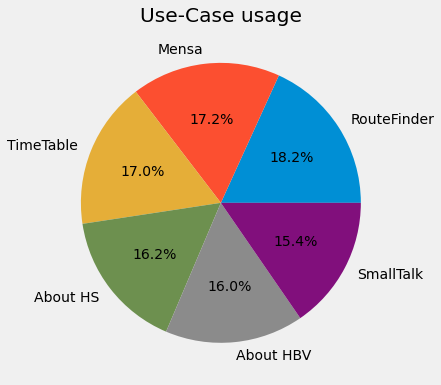

In [7]:
use_case_df["use_case"].value_counts().plot(kind="pie", autopct="%1.1f%%")
plt.title("Use-Case usage");
plt.axis("off")
plt.show()

_____

Do more women or men use our Ppepper-Application?

(-1.25, 1.25, -1.25, 1.25)

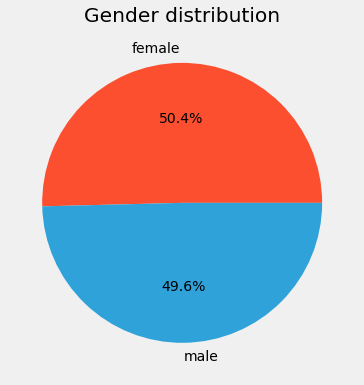

In [8]:
emotion_states_df.gender.value_counts().plot(kind="pie",  autopct="%1.1f%%", colors = [ _red, _blue ])
plt.title("Gender distribution");
plt.axis("off")

______

How happy are the users of our application?

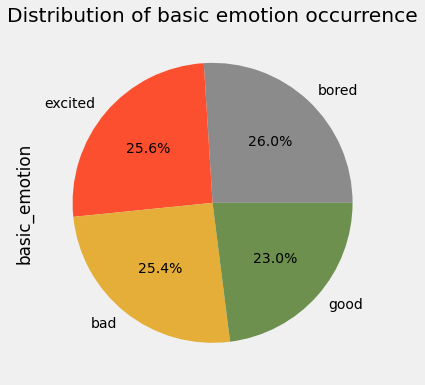

In [9]:
emotion_states_df["basic_emotion"].value_counts().plot(kind="pie", autopct="%1.1f%%",colors = [ _gray, _red, _orange, _green])
plt.title("Distribution of basic emotion occurrence");

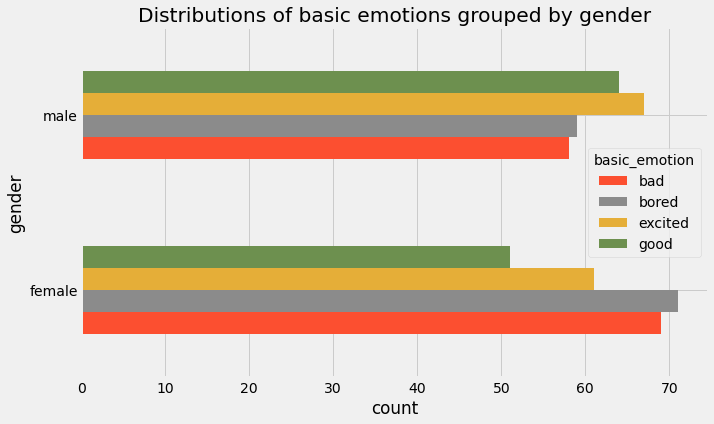

In [10]:
pd.concat(
    [emotion_states_df[["gender", "basic_emotion"]].pivot_table(index=["gender"], columns=col, aggfunc=len) for col in ["basic_emotion"]], axis = 1
).fillna(0).plot(kind = "barh", color = { "bad": _red, "bored": _gray, "excited": _orange, "good": _green }    )
plt.title("Distributions of basic emotions grouped by gender")
plt.xlabel("count");

______

In [11]:
pd.concat(
    [emotion_states_df[["gender", "pleasure_state"]].pivot_table(index=["gender"], columns=col, aggfunc=len) for col in ["pleasure_state"]], axis=1
).fillna(0)

pleasure_state,bad,good,medium,perfect
gender,,,,
female,58,59,69,66
male,59,59,56,74


Text(0.5, 1.0, 'Distribution of pleasure states grouped by gender.')

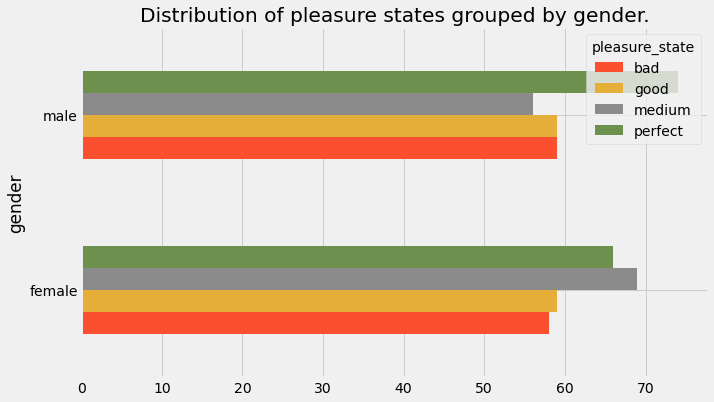

In [12]:
pd.concat(
    [emotion_states_df[["gender", "pleasure_state"]].pivot_table(index=["gender"], columns=col, aggfunc=len) for col in ["pleasure_state"]], axis=1
).fillna(0).plot(kind="barh", color={ "bad": _red, "medium": _gray, "good": _orange, "perfect": _green })
plt.title("Distribution of pleasure states grouped by gender.")

____
## 3.2 Weekly data <a name="weeklydata"></a>

In [13]:
query_str = f"WHERE ts > NOW() - INTERVAL {7} day"
        
emotion_states_df_7days = pd.DataFrame(data=client.sql_query(f"SELECT * FROM pepper_emotion_table {query_str}"))
not_understand_df_7days = pd.DataFrame(data=client.sql_query(f"SELECT * FROM pepper_did_not_understand_table {query_str}"))
use_case_df_7days = pd.DataFrame(data=client.sql_query(f"SELECT * FROM pepper_use_case_table {query_str}"))

# preprocessing
emotion_states_df_7days["dialog_time"] = np.array([x for x in emotion_states_df_7days["dialog_time"]]).astype("float32")

In [14]:
d = emotion_states_df_7days[["distance", "gender", "age", "basic_emotion", "pleasure_state", "excitement_state", "smile_state", "dialog_time", "ts"]]
d_use_case = use_case_df_7days[["use_case", "ts"]]

In [15]:
if False: # if there is enough data in DB, else create some random weekday data
    for i, ts in enumerate(d["ts"]):
        date_obj = datetime.strptime(ts, "%Y-%m-%dT%H:%M:%S.000Z")
        d["ts"][i] = f"{date_obj.day}.{date_obj.month}.{date_obj.year} {date_obj.hour}:{date_obj.minute}"

    for i, ts in enumerate(d_use_case["ts"]):
        date_obj = datetime.strptime(ts, "%Y-%m-%dT%H:%M:%S.000Z")
        d_use_case["ts"][i] = f"{date_obj.day}.{date_obj.month}.{date_obj.year} {date_obj.hour}:{date_obj.minute}"
        
else:
    for i, ts in enumerate(d["ts"]):
        date_obj = datetime.strptime(ts, "%Y-%m-%dT%H:%M:%S.000Z")
        d["ts"][i] = f"{np.random.randint(24, 31)}.{date_obj.month}.{date_obj.year} {date_obj.hour}:{date_obj.minute}"

    for i, ts in enumerate(d_use_case["ts"]):
        date_obj = datetime.strptime(ts, "%Y-%m-%dT%H:%M:%S.000Z")
        d_use_case["ts"][i] = f"{np.random.randint(24, 31)}.{date_obj.month}.{date_obj.year} {date_obj.hour}:{date_obj.minute}"

d["weekday"] = [datetime.strptime(ts, "%d.%m.%Y %H:%M").weekday() for ts in d["ts"]]
d_use_case["weekday"] = [datetime.strptime(ts, "%d.%m.%Y %H:%M").weekday() for ts in d_use_case["ts"]]

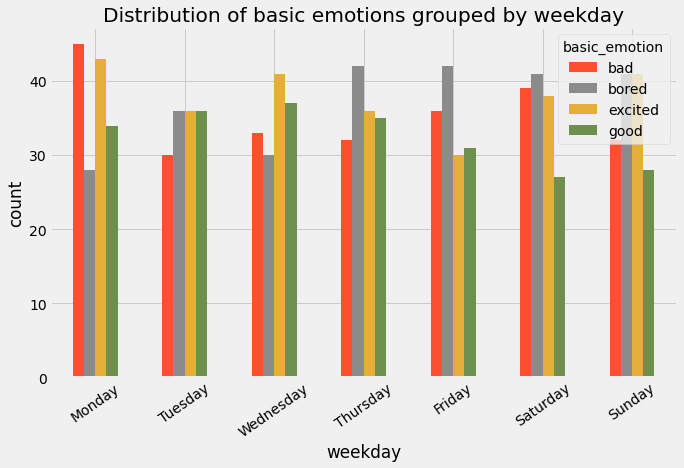

In [16]:
pd.concat(
    [d[["weekday", "basic_emotion"]].pivot_table(index=["weekday"], columns=col, aggfunc=len) for col in ["basic_emotion"]], axis = 1
).fillna(0).plot(kind = "bar", color = { "bad": _red, "bored": _gray, "excited": _orange, "good": _green }, rot = 35)

plt.title("Distribution of basic emotions grouped by weekday")
plt.xticks(np.arange(len(plt.gca().get_xticklabels())), [_weekdays[int(i.get_text())] for i in plt.gca().get_xticklabels()])
plt.xlabel("weekday")
plt.ylabel("count");

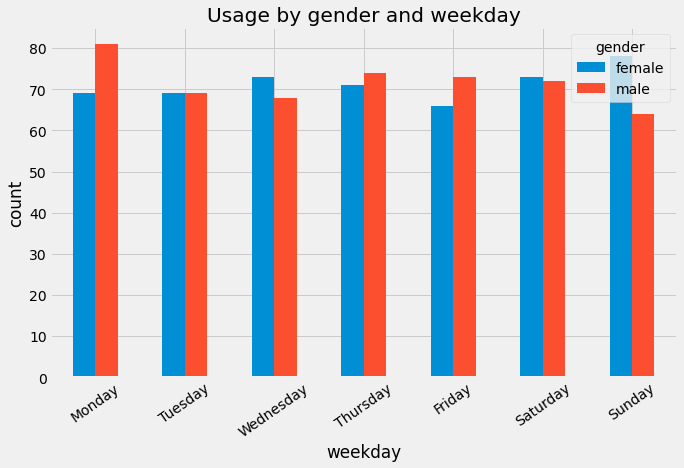

In [17]:
pd.concat(
    [d[["weekday", "gender"]].pivot_table(index=["weekday"], columns=col, aggfunc=len) for col in ["gender"]], axis = 1
).fillna(0).plot(kind = "bar", rot = 35)

plt.title("Usage by gender and weekday")
plt.xticks(np.arange(len(plt.gca().get_xticklabels())), [_weekdays[int(i.get_text())] for i in plt.gca().get_xticklabels()])
plt.xlabel("weekday")
plt.ylabel("count");

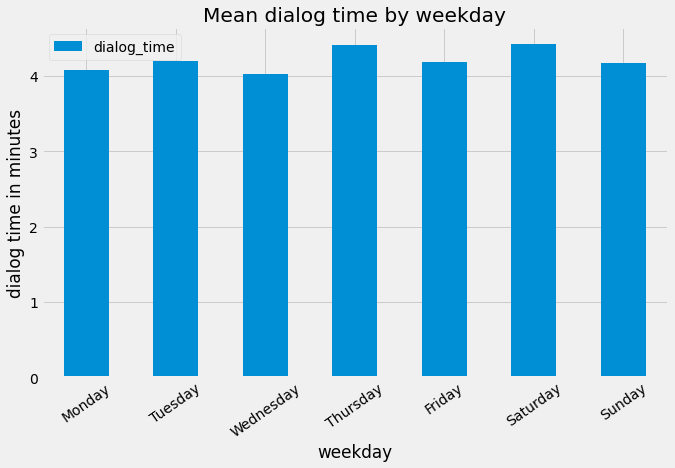

In [18]:
d[["weekday", "dialog_time"]].groupby("weekday").mean().plot(kind="bar", rot=35)
plt.title("Mean dialog time by weekday")
plt.xticks(np.arange(len(plt.gca().get_xticklabels())), [_weekdays[int(i.get_text())] for i in plt.gca().get_xticklabels()])
plt.xlabel("weekday")
plt.ylabel("dialog time in minutes");

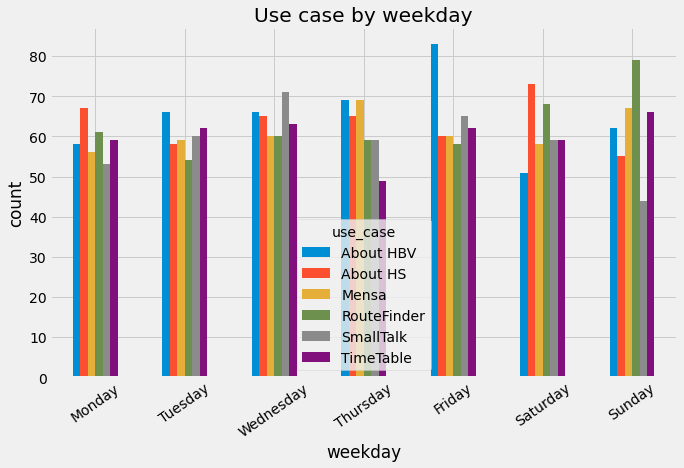

In [19]:
pd.concat(
    [d_use_case[["weekday", "use_case"]].pivot_table(index=["weekday"], columns=col, aggfunc=len) for col in ["use_case"]],axis = 1
).fillna(0).plot(kind = "bar", rot = 35)

plt.title("Use case by weekday")
plt.xticks(np.arange(len(plt.gca().get_xticklabels())), [_weekdays[int(i.get_text())] for i in plt.gca().get_xticklabels()])
plt.xlabel("weekday")
plt.ylabel("count");

_____

## 3.3 Let's do some linear regression! <a name="lr"> </a>

In [20]:
emotion_states_df

,data_id,identifier,distance,age,gender,basic_emotion,pleasure_state,excitement_state,smile_state,dialog_time,ts
0,1,1015d2c850c14f749b1217cb5eca016d,0.7243,73,female,excited,good,not excited,false,3.26,2022-01-11T14:20:33.000Z
1,2,d064d1130f694343b89426531b6505ec,0.5726,35,male,bored,good,excited,false,3.59,2022-01-11T14:20:34.000Z
2,3,eb60dbcc988d409dbc561cb398f363e8,1.1039,37,male,good,perfect,excited,true,5.88,2022-01-11T14:20:34.000Z
3,4,52023cd3cd32432881dd20b9130f7c30,0.6094,28,male,good,bad,excited,false,4.41,2022-01-11T14:20:35.000Z
4,5,074bb1ef06bc4e359b498974730aa456,0.816,48,female,bad,good,excited,false,2.81,2022-01-11T14:20:36.000Z
...,...,...,...,...,...,...,...,...,...,...,...
495,496,6e2bdcdc72f14a8786b52dc7c2a19026,0.2919,37,female,good,good,excited,medium,3.49,2022-01-13T07:37:03.000Z
496,497,5756a157c20c403d9f17bd038be5d55d,0.5582,25,male,excited,bad,not excited,medium,6.60,2022-01-13T07:37:03.000Z
497,498,b21f375a04784ee092ade5054b265fc2,1.9582,72,female,excited,good,not excited,false,3.66,2022-01-13T07:37:03.000Z
498,499,4e062bf849804710bc538d6320c014cd,1.2316,19,male,excited,bad,excited,true,3.43,2022-01-13T07:37:03.000Z


In [21]:
# select only necessary columns
data = emotion_states_df[["distance", "age", "gender", "basic_emotion", "pleasure_state", "excitement_state", "smile_state", "dialog_time"]];data

,distance,age,gender,basic_emotion,pleasure_state,excitement_state,smile_state,dialog_time
0,0.7243,73,female,excited,good,not excited,false,3.26
1,0.5726,35,male,bored,good,excited,false,3.59
2,1.1039,37,male,good,perfect,excited,true,5.88
3,0.6094,28,male,good,bad,excited,false,4.41
4,0.816,48,female,bad,good,excited,false,2.81
...,...,...,...,...,...,...,...,...
495,0.2919,37,female,good,good,excited,medium,3.49
496,0.5582,25,male,excited,bad,not excited,medium,6.60
497,1.9582,72,female,excited,good,not excited,false,3.66
498,1.2316,19,male,excited,bad,excited,true,3.43


In [22]:
# age
X = data.iloc[:, 1].values.reshape(-1, 1).astype("int")
# dialog_time
Y = data.iloc[:, -1].values.reshape(-1, 1).astype("float32")
linear_regressor = LinearRegression() 
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

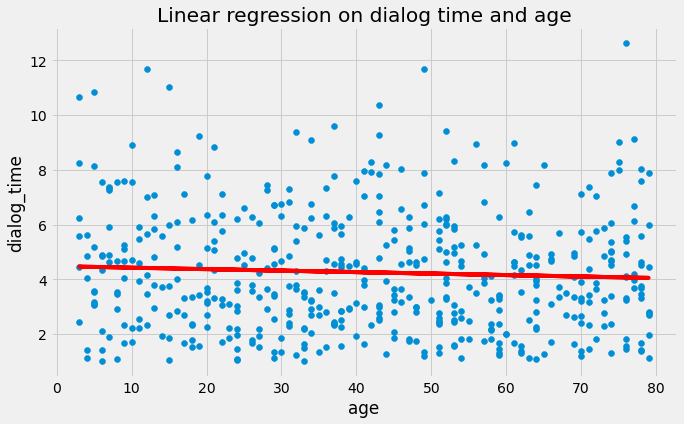

In [23]:
plt.scatter(X, Y)
plt.plot(X, Y_pred, color="red")
plt.xlabel("age")
plt.ylabel("dialog_time")
plt.title("Linear regression on dialog time and age");

Even if the data are not representative, one could see here that the duration of conversations decreases with increasing age.

_____

## 3.4 Are there any correlations? <a name="corr"> </a>

In [24]:
# load a fresh set of data
data = pd.DataFrame(client.sql_query("SELECT distance, age, gender, basic_emotion, pleasure_state, excitement_state, smile_state, dialog_time FROM pepper_emotion_table")); data

,distance,age,gender,basic_emotion,pleasure_state,excitement_state,smile_state,dialog_time
0,0.7243,73,female,excited,good,not excited,false,3.26
1,0.5726,35,male,bored,good,excited,false,3.59
2,1.1039,37,male,good,perfect,excited,true,5.88
3,0.6094,28,male,good,bad,excited,false,4.41
4,0.816,48,female,bad,good,excited,false,2.81
...,...,...,...,...,...,...,...,...
2142,0.7718,50,male,excited,good,not excited,medium,3.89
2143,0.39,40,female,bored,medium,not excited,false,4.38
2144,1.4162,63,female,bad,good,excited,true,6.13
2145,0.3747,15,male,bad,bad,excited,false,4.52


In [25]:
# change strings to integer and float values 
for column in ["gender", "basic_emotion", "pleasure_state", "excitement_state", "smile_state"]:
    unique_vals = data[column].unique()
    data[column].replace(
        to_replace=unique_vals,
        value=np.array(range(len(unique_vals))).astype("float32"),
        inplace=True
    )
data["distance"] = np.asarray(data["distance"]).astype("float32")
data["age"] = np.asarray(data["age"]).astype("int")
data["dialog_time"] = np.asarray(data["dialog_time"]).astype("float32")

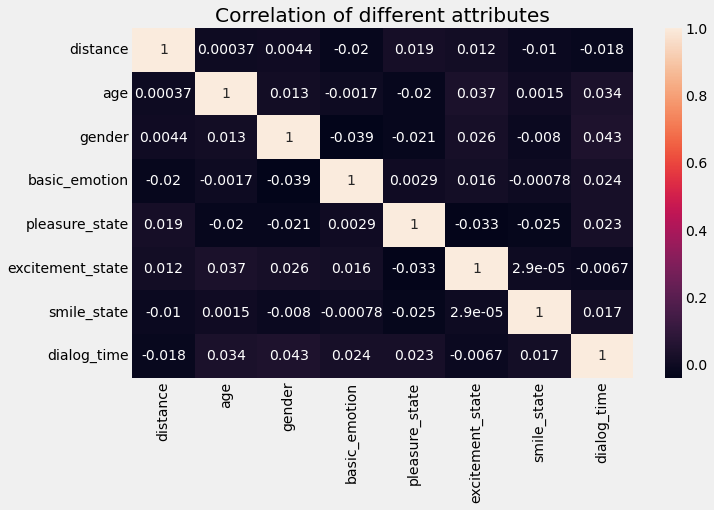

In [26]:
corr = data.corr()
sns.heatmap(
    corr,
    xticklabels=corr.columns,
    yticklabels=corr.columns, 
    annot=True
)
plt.title("Correlation of different attributes");

In [27]:
corr

,distance,age,gender,basic_emotion,pleasure_state,excitement_state,smile_state,dialog_time
distance,1.000000,0.000369,0.004369,-0.019891,0.018871,0.011949,-0.010286,-0.018051
age,0.000369,1.000000,0.012824,-0.001659,-0.019517,0.037176,0.001542,0.034047
gender,0.004369,0.012824,1.000000,-0.039181,-0.020973,0.025620,-0.008042,0.043095
basic_emotion,-0.019891,-0.001659,-0.039181,1.000000,0.002879,0.015514,-0.000778,0.024288
pleasure_state,0.018871,-0.019517,-0.020973,0.002879,1.000000,-0.033429,-0.024538,0.022709
excitement_state,0.011949,0.037176,0.025620,0.015514,-0.033429,1.000000,0.000029,-0.006736
smile_state,-0.010286,0.001542,-0.008042,-0.000778,-0.024538,0.000029,1.000000,0.016999
dialog_time,-0.018051,0.034047,0.043095,0.024288,0.022709,-0.006736,0.016999,1.000000


____

## 3.5 Time for TensorFlow! <a name="tf"> </a>

The goal is to create a model, that can then be used, to determine the age of users, based on the underlying informaiton.

(We will take the same data, loaded in the previos step)

In [28]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2) # devide in test and tran data

In [29]:
train

,distance,age,gender,basic_emotion,pleasure_state,excitement_state,smile_state,dialog_time
1309,1.9015,49,1.0,1.0,3.0,0.0,2.0,6.89
1606,0.2721,16,0.0,1.0,1.0,1.0,1.0,4.26
419,0.7585,57,1.0,2.0,2.0,1.0,2.0,4.03
2139,0.3691,13,1.0,0.0,3.0,1.0,1.0,4.90
1668,0.6071,21,1.0,3.0,3.0,1.0,2.0,5.49
...,...,...,...,...,...,...,...,...
2142,0.7718,50,1.0,0.0,0.0,0.0,2.0,3.89
1450,0.1844,49,1.0,3.0,1.0,1.0,2.0,5.07
257,0.3313,18,0.0,1.0,2.0,1.0,1.0,2.32
1209,0.8543,66,1.0,2.0,0.0,0.0,2.0,3.11


In [30]:
var_to_predict = "gender"

train_target = np.asarray(train.pop(var_to_predict)).astype("int")
train_data = np.asarray(train).astype("float32")

test_target = np.asarray(test.pop(var_to_predict)).astype("int")
test_data = np.asarray(test).astype("float32")


In [31]:
numeric_features = tf.convert_to_tensor(train_data)
normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)
normalizer.adapt(numeric_features)

2022-01-24 10:46:43.099541: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
def get_basic_model():
    # function to create a fully-connected network structure with four layers
    model = tf.keras.Sequential([
        normalizer,
        tf.keras.layers.Dense(18, input_dim=7, activation="relu"), # relu = best performance
        tf.keras.layers.Dense(12, activation="relu"),
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid") # to ensure that output is 0 or 1 OR male or female
    ])

    model.compile(
        optimizer="adam", # Adam version of stochastic gradient descent
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )

    return model

In [33]:
# create the model 
model = get_basic_model()
# train the model
model.fit(numeric_features, train_target, epochs=20, batch_size=5, verbose=4)

2022-01-24 10:46:43.611767: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


In [34]:
# evaluate the model
_, accuracy = model.evaluate(test_data, test_target)
print("Accuracy: %.2f" % (accuracy*100))

14/14 [==============================] - 0s 2ms/step - loss: 0.7137 - accuracy: 0.5279
Accuracy: 52.79


Haha not really good, maybe because our data is just dummy generated by script. 👀

In [35]:
# make probability predictions with the model
predictions = model.predict(numeric_features)
# round predictions 
rounded = [round(x[0]) for x in predictions]
# make class predictions with the model
#predictions = (model.predict(X) > 0.5).astype(int)

In [36]:
n = 100
print(f"Accurancy: {len([i for i in range(n) if list(rounded)[:n][i] == list(train_target)[:n][i]])/n*100}%")     

Accurancy: 56.00000000000001%
